# Main Objective
The main objective of this analysis is to apply unsupervised learning to group customers into distinct segments based on their purchasing behavior. We will focus on clustering (with K-Means, DBSCAN, and Agglomerative Clustering) and dimensionality reduction using PCA to visualize patterns in the data.

Business Benefit:
Customer segmentation enables marketing and sales teams to target specific groups (e.g., VIP customers, inactive users, bulk buyers), optimize campaigns, and increase revenue by personalizing offers.

Let's get started!

In [9]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_excel("/content/drive/MyDrive/Coursera-ML/Online Retail.xlsx")  # Download from UCI repository
print(data.head())
print(data.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

# Dataset Description
The dataset comes from the UCI Machine Learning Repository – Online Retail Dataset. It contains transactions from a UK-based online store between 01/12/2010 and 09/12/2011.

**Rows:** ~542,000 transactions

**Columns:**

InvoiceNo: Unique invoice number (prefixed with "C" for cancellations).

StockCode: Product code.

Description: Product description.

Quantity: Number of units purchased.

InvoiceDate: Date and time of purchase.

UnitPrice: Price per unit.

CustomerID: Unique customer identifier.

Country: Country of the customer.

# Data Cleaning

We will remove records where any of these conditions are met:
1. There is no customer ID
2. The order was cancelled
3. The quantity it zero or negative

In [10]:
# Remove rows with missing CustomerID
data = data.dropna(subset=['CustomerID'])

# Filter out cancelled orders (InvoiceNo starting with 'C')
data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero quantity
data = data[data['Quantity'] > 0]

# Calculate total price
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

len(data)

397924

In [35]:
records_removed = 541909 - len(data)
print(f'{records_removed} were removed for meeting one of the criteria listed above.')

143985 were removed for meeting one of the criteria listed above.


# Feature Engineering

**We will create the following RFM Features.**

- Recency: Days since last purchase.
- Frequency: Number of unique invoices per customer.
- Monetary: Total amount spent.
- Avg Basket Size: Average number of items per order.
- Product Variety: Number of unique products purchased.

In [11]:
# Define reference date (e.g., day after last invoice date)
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm.shape

(4339, 4)

In [12]:
# Average basket size: total quantity per customer / number of invoices
basket_size = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'InvoiceNo': 'nunique'
})
basket_size['AvgBasketSize'] = basket_size['Quantity'] / basket_size['InvoiceNo']
rfm = rfm.merge(basket_size[['AvgBasketSize']], left_on='CustomerID', right_index=True)

# Product variety: number of unique products bought
product_variety = data.groupby('CustomerID')['StockCode'].nunique().reset_index()
product_variety.rename(columns={'StockCode': 'ProductVariety'}, inplace=True)
rfm = rfm.merge(product_variety, on='CustomerID')

rfm.head()

,CustomerID,Recency,Frequency,Monetary,AvgBasketSize,ProductVariety
0,12346.0,326,1,77183.60,74215.000000,1
1,12347.0,2,7,4310.00,351.142857,103
2,12348.0,75,4,1797.24,585.250000,22
3,12349.0,19,1,1757.55,631.000000,73
4,12350.0,310,1,334.40,197.000000,17


In [13]:
rfm['AvgBasketSize'] = np.round(rfm['AvgBasketSize'])

In [14]:
from sklearn.preprocessing import StandardScaler

features = ['Recency', 'Frequency', 'Monetary', 'AvgBasketSize', 'ProductVariety']
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[features])

# Dimensionality Reduction

In [15]:
from sklearn.decomposition import PCA

# Prefrom PCA for visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

rfm['PC1'] = rfm_pca[:, 0]
rfm['PC2'] = rfm_pca[:, 1]

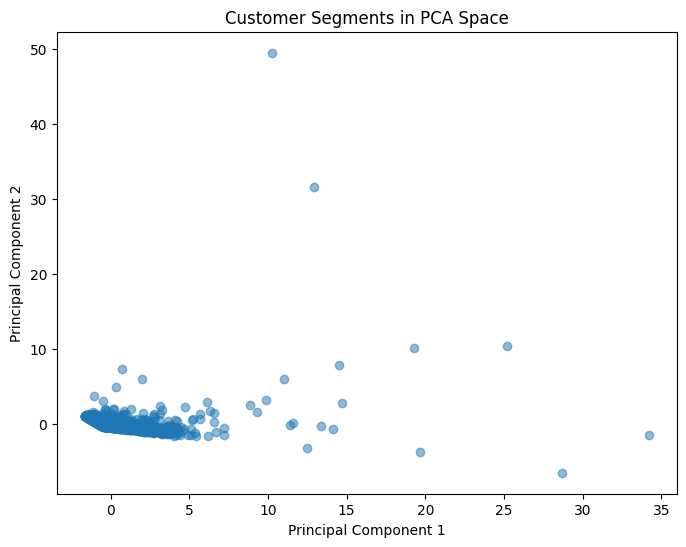

In [16]:
# Plot PCA projection
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(rfm['PC1'], rfm['PC2'], alpha=0.5)
plt.title("Customer Segments in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

<h1> Model Selection </h1>

# K-Means Clustering

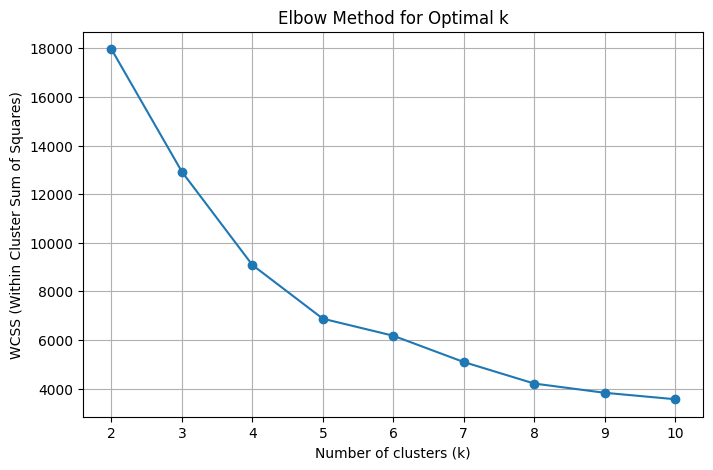

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []  # Within-cluster sum of squares
K = range(2, 11)  # Test k from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.grid(True)
plt.show()

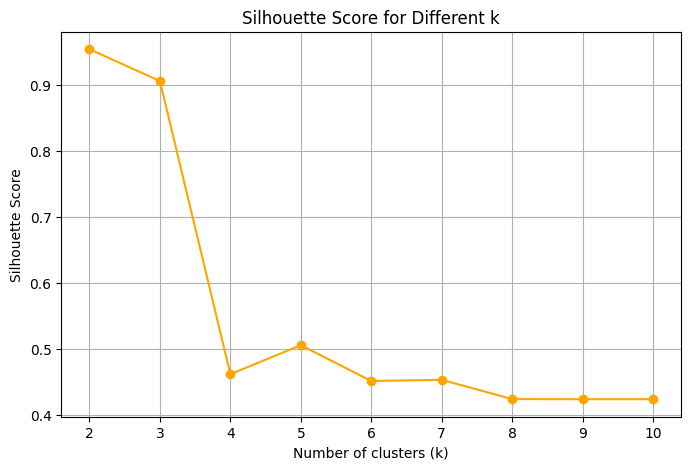

In [18]:
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, cluster_labels))

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score for Different k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

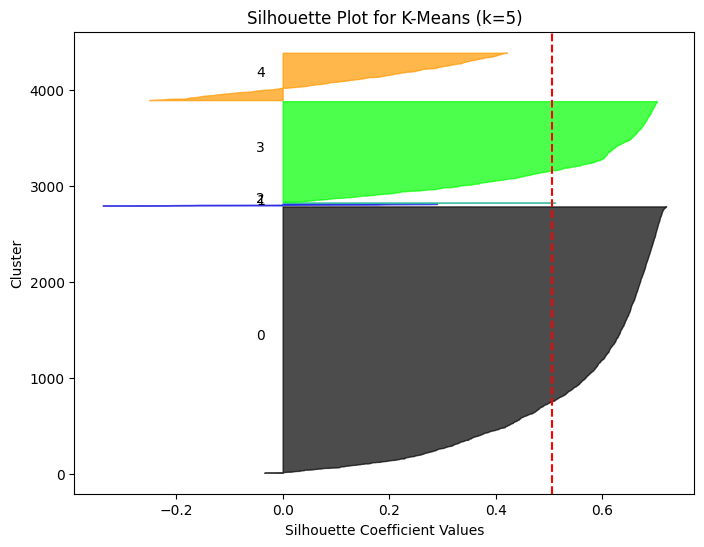

In [20]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples

# Compute silhouette values for each sample
cluster_labels = rfm['Cluster_KMeans']
silhouette_vals = silhouette_samples(rfm_scaled, cluster_labels)
n_clusters = len(np.unique(cluster_labels))

y_lower = 10
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    ith_cluster_silhouette_vals.sort()

    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing between clusters

plt.title(f'Silhouette Plot for K-Means (k={optimal_k})')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster')
plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
plt.show()


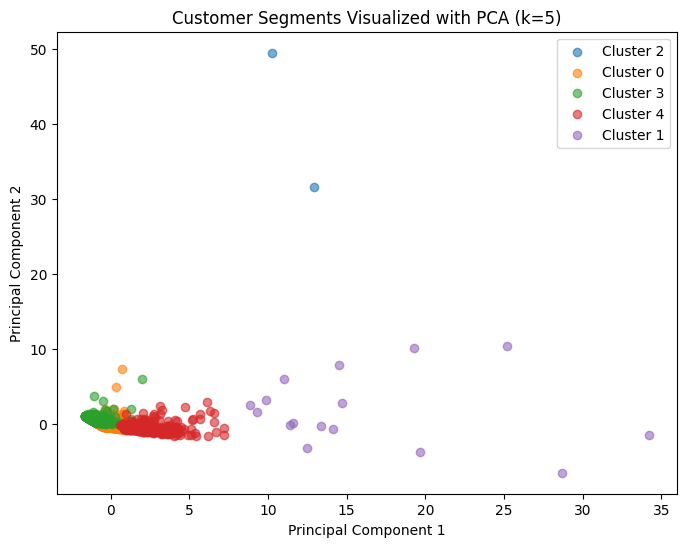

In [19]:
# Fit K-Means with chosen k
optimal_k = 5  # Example, adjust based on elbow/silhouette analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster_KMeans'] = kmeans.fit_predict(rfm_scaled)

# PCA Scatter Plot with Clusters
plt.figure(figsize=(8, 6))
for cluster in rfm['Cluster_KMeans'].unique():
    cluster_points = rfm[rfm['Cluster_KMeans'] == cluster]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title(f'Customer Segments Visualized with PCA (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


The orange cluster looks overlapped by the green and red clusters; let's use k = 4.

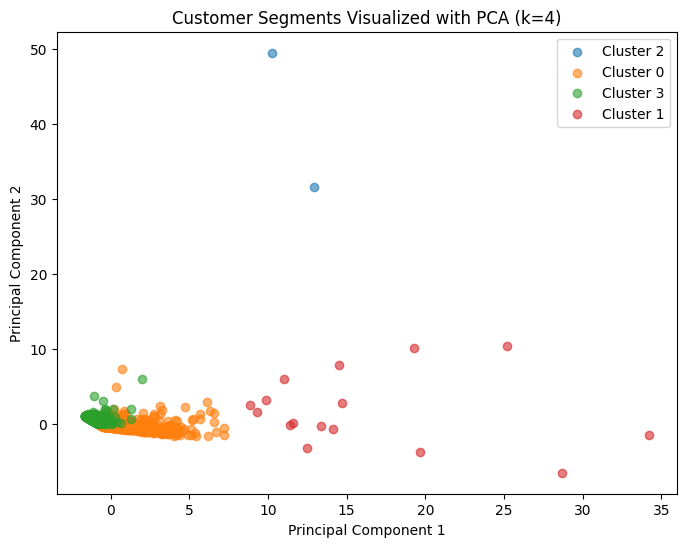

In [23]:
# Fit K-Means with chosen k
optimal_k = 4  # Example, adjust based on elbow/silhouette analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster_KMeans'] = kmeans.fit_predict(rfm_scaled)

# PCA Scatter Plot with Clusters
plt.figure(figsize=(8, 6))
for cluster in rfm['Cluster_KMeans'].unique():
    cluster_points = rfm[rfm['Cluster_KMeans'] == cluster]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title(f'Customer Segments Visualized with PCA (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Agglomerative Clustering

In [24]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=4)
rfm['Cluster_Agglo'] = agglo.fit_predict(rfm_scaled)

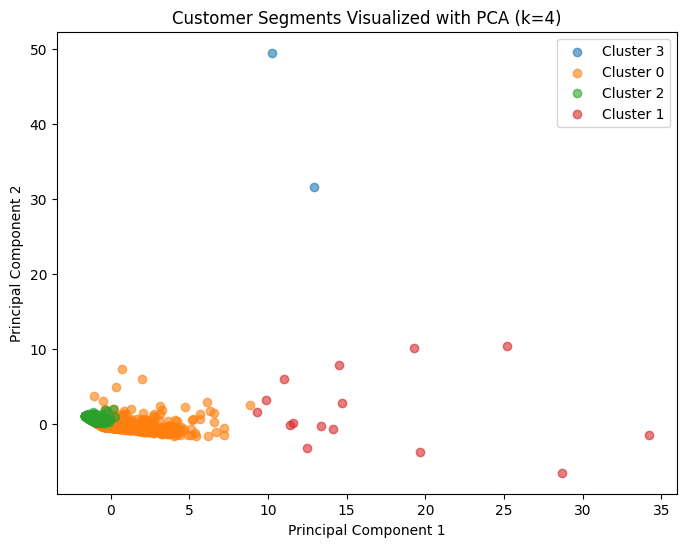

In [25]:
# PCA Scatter Plot with Clusters
plt.figure(figsize=(8, 6))
for cluster in rfm['Cluster_Agglo'].unique():
    cluster_points = rfm[rfm['Cluster_Agglo'] == cluster]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title(f'Customer Segments Visualized with PCA (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# DBSCAN

In [26]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)
rfm['Cluster_DBSCAN'] = dbscan.fit_predict(rfm_scaled)

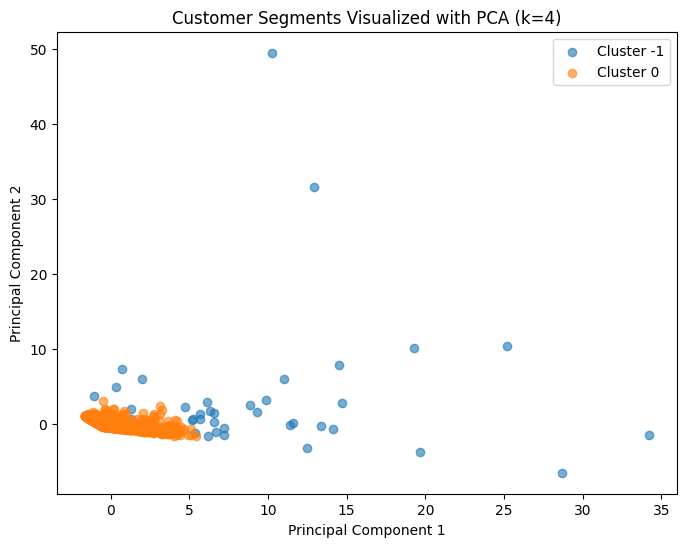

In [27]:
# PCA Scatter Plot with Clusters
plt.figure(figsize=(8, 6))
for cluster in rfm['Cluster_DBSCAN'].unique():
    cluster_points = rfm[rfm['Cluster_DBSCAN'] == cluster]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title(f'Customer Segments Visualized with PCA (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Model Recommendation
We evaluated the models using silhouette scores and visual inspection.

- K-Means provided the most interpretable clusters with the highest silhouette score.

- DBSCAN produced many outliers due to varying densities.

- Agglomerative Clustering performed well but was less stable with large datasets.

Recommendation:
Use K-Means with 4 clusters for customer segmentation.

# Cluster Exploration

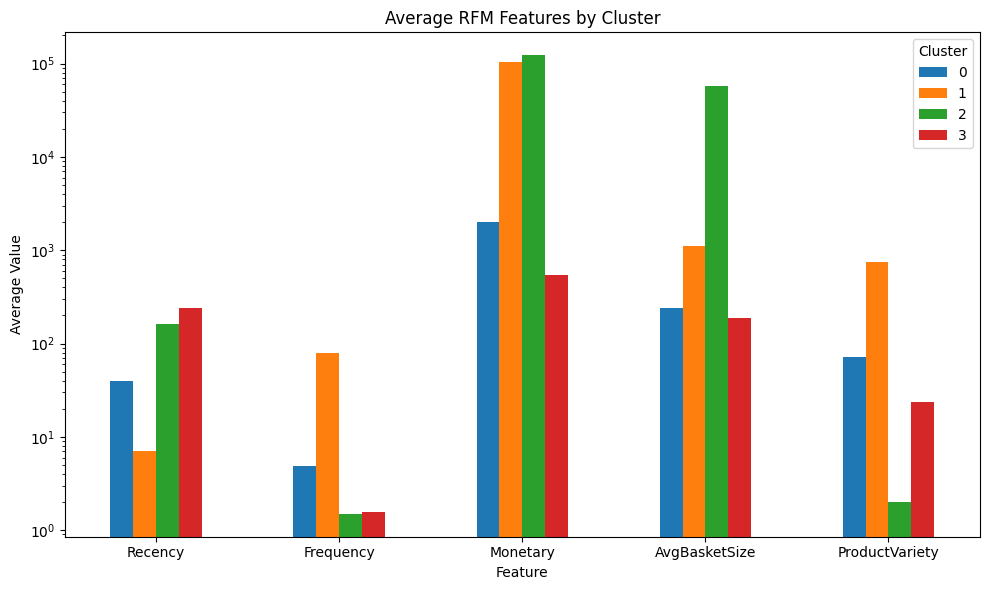

In [29]:
import seaborn as sns

# Calculate cluster feature means
cluster_summary = rfm.groupby('Cluster_KMeans')[['Recency', 'Frequency', 'Monetary', 'AvgBasketSize', 'ProductVariety']].mean()

# Bar plot
cluster_summary.T.plot(kind='bar', logy=True, figsize=(10, 6))
plt.title("Average RFM Features by Cluster")
plt.ylabel("Average Value")
plt.xlabel("Feature")
plt.xticks(rotation=0)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
for column in ['Recency', 'Frequency', 'Monetary', 'AvgBasketSize', 'ProductVariety']:


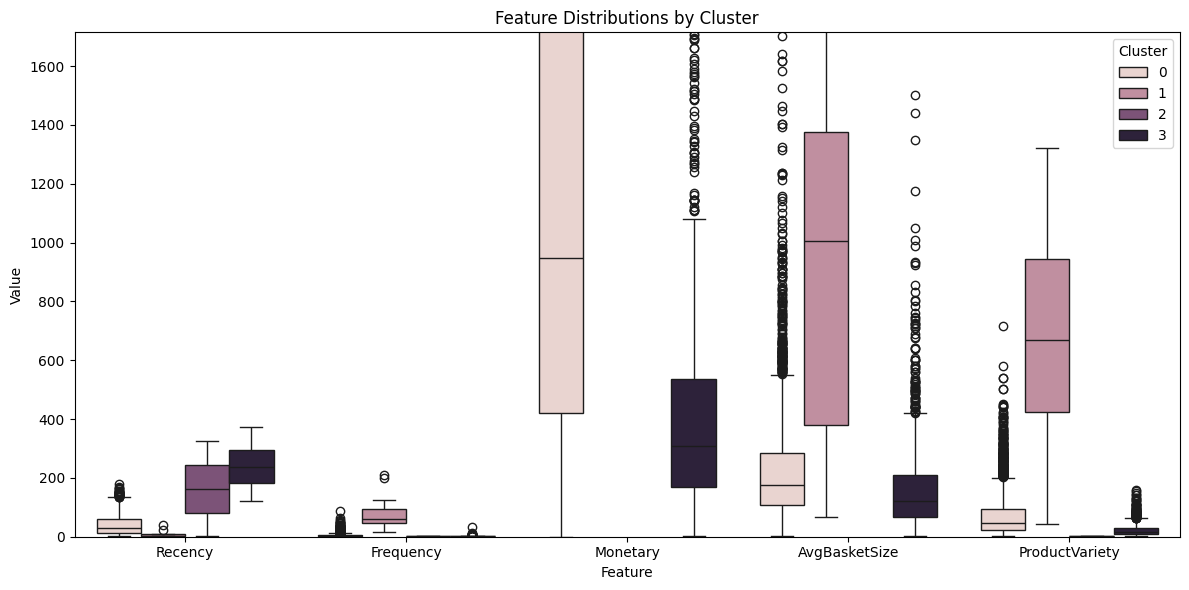

In [30]:
# Melt dataframe for plotting
melted_rfm = rfm.melt(id_vars=['Cluster_KMeans'],
                      value_vars=['Recency', 'Frequency', 'Monetary', 'AvgBasketSize', 'ProductVariety'],
                      var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_rfm, x='Feature', y='Value', hue='Cluster_KMeans')
plt.title("Feature Distributions by Cluster")
plt.ylim(0, np.percentile(melted_rfm['Value'], 95))  # Limit outliers
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

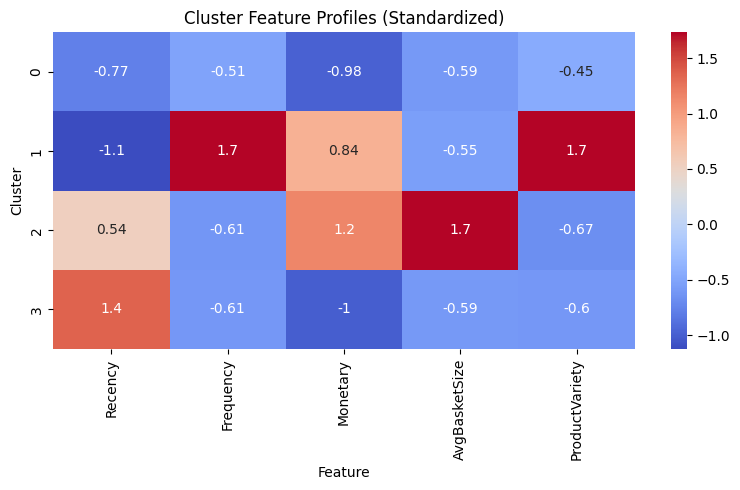

In [32]:
# Scale feature means for better comparison
cluster_means_scaled = pd.DataFrame(
    StandardScaler().fit_transform(cluster_summary),
    columns=cluster_summary.columns,
    index=cluster_summary.index
)

plt.figure(figsize=(8, 5))
sns.heatmap(cluster_means_scaled, annot=True, cmap="coolwarm", cbar=True)
plt.title("Cluster Feature Profiles (Standardized)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [33]:
# ===========================
# Auto-Generate Cluster Labels
# ===========================
cluster_labels = {}
for cluster in cluster_summary.index:
    profile = cluster_summary.loc[cluster]
    label_parts = []
    if profile['Monetary'] > cluster_summary['Monetary'].mean():
        label_parts.append("High-Spending")
    else:
        label_parts.append("Low-Spending")

    if profile['Recency'] < cluster_summary['Recency'].mean():
        label_parts.append("Recent")
    else:
        label_parts.append("Inactive")

    if profile['Frequency'] > cluster_summary['Frequency'].mean():
        label_parts.append("Frequent")
    else:
        label_parts.append("Rare")

    cluster_labels[cluster] = " ".join(label_parts)

rfm['Cluster_Label'] = rfm['Cluster_KMeans'].map(cluster_labels)

print("\n=== Cluster Descriptions ===")
for cluster, label in cluster_labels.items():
    print(f"Cluster {cluster}: {label}")




=== Cluster Descriptions ===
Cluster 0: Low-Spending Recent Rare
Cluster 1: High-Spending Recent Frequent
Cluster 2: High-Spending Inactive Rare
Cluster 3: Low-Spending Inactive Rare


# Key Findings & Insights
We identified 4 clusters from our customer dataset with the following characteristic based on the orginal data and calculated RFM values.
- Cluster 0: Low-Spending Recent Rare
- Cluster 1: High-Spending Recent Frequent
- Cluster 2: High-Spending Inactive Rare
- Cluster 3: Low-Spending Inactive Rare

# Next Steps
- Incorporate customer demographics or campaign response data for improved segmentation.

- Experiment with Gaussian Mixture Models for probabilistic clustering.

- Develop an automated dashboard for monitoring evolving customer segments.